In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.api as sm
# import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.utility_functions as ut
import resources.abundance_classes as ac
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2015-11-01'
end_date ='2021-05-31'

unit_label = 'p/100m'

unit_value = 100

fail_rate = 50

sns.set_style('whitegrid')

# colors for gradients
colors = ['beige', 'navajowhite', 'sandybrown', 'salmon', 'sienna']
nodes = [0.0, 0.2, 0.6, 0.8, 1.0]
cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

# colors for projects
this_palette = {"2020":"dodgerblue", "2018":"magenta"}

# name of the output folder:
name_of_project = 'time_series_2018_2020'

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# get your data:
survey_data = pd.read_csv('resources/inprocess/agg_results_with_land_use_2015.csv')
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True)
wname_wname.set_index('water_name_slug', inplace=True)

# map water name slug to type
wname_type = dfBeaches[["water_name_slug", "water"]].reset_index(drop=True)

# convenience function for doing land use correlations
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    return ax, corr, a_p

# index the code data
dfCodes.set_index("code", inplace=True)

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G81", "description", "Expanded foams .5cm - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G117", "description", "Expanded foams < 5mm"], dfCodes)
dfCodes = sut.shorten_the_value(["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G24", "description", "Plastic lid rings"], dfCodes)
dfCodes = sut.shorten_the_value(["G33", "description", "Lids for togo drinks plastic"], dfCodes)
dfCodes = sut.shorten_the_value(["G3", "description", "Plastic bags, carier bags"], dfCodes)
dfCodes = sut.shorten_the_value(["G204", "description", "Bricks, pipes not plastic"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code materials
code_material_map = dfCodes.material

(slr-iqaasl)=
# More and less since 2018

The first national beach litter report was produced in 2018. The Swiss Litter Report (SLR) was a project intiated by Gabriele Kuhl {cite}`stoppp` and supported by the World Wildlife Fund Switzerland {cite}`wwf`. The protocol was bassed on the _Guide for monitoring marine litter_ {cite}`mlwguidance`, the project was managed by the WWF and the surveys were conducted by volunteers from both organizations. Starting in April 2017 and running to March 2018 the SLR covered much of the national territory with the exception of Ticino.

The SLR collected 1,052 samples from 112 locations. More than 150 trained volunteers from 81 municipalities collected and categorized 98,474 pieces of trash from the shores of 48 lakes and 67 rivers in Switzerland. {cite}`slr`

The most obvious question is: __Was there more or less trash observed in 2020 than 2018?__. To answer that question the survey locations from each project were first compared on the basis of the land use profile within 1500m of each survey location for each project. Then the survey results were limited to:

1. Rivers and lakes that had samples in both years
2. Only objects that were identified in 2018 were considered

From this subset of data the median survey total of all objects and the average survey total of the most common objects were compared to identify statistically significant changes in either direction from one project to the next. This test was conducted on two groups of the subset:

1. Rivers and lakes combined with samples from both projects
2. Only the lakes with samples from both projects

## Scope of projects SLR - IQAASL


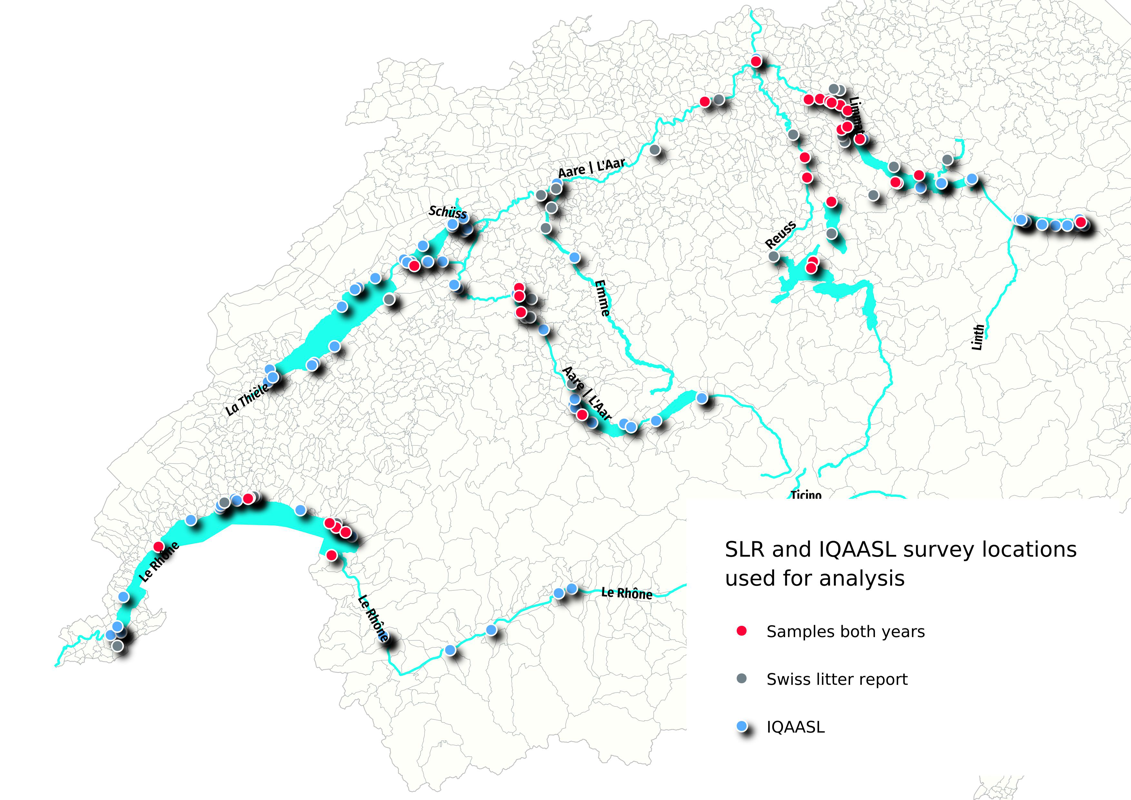

In [2]:
bassin_map = PILImage.open("resources/maps/slr_iqasl.jpeg")

output = io.BytesIO()
bassin_map.thumbnail((1200, 800))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

In [3]:
# make sure date is time stamp
survey_data['date'] = pd.to_datetime(survey_data['date'], format='%Y-%m-%d')

# identify any misnamed river bassin or survey area ids
na_bassins = survey_data[survey_data.river_bassin == '0'].copy()

# keep the river bassins that are valid
valid_bassins = survey_data[survey_data.river_bassin != '0'].copy()

# get only the water features that were sampled in 2020
after_2020 = valid_bassins[valid_bassins.date >= '2020-01-01'].water_name_slug.unique()
a_data = survey_data[survey_data.water_name_slug.isin(after_2020)]

# get rid of a duplicate sample
a_data = a_data[(a_data.location != "lac-leman-hammerdirt")]

# convert pcs-m to unit_value
a_data['pcs_m'] = a_data.pcs_m * unit_value
a_data['pcs_m'] = a_data.pcs_m.astype('int')

# rename the column
a_data.rename(columns={'pcs_m':unit_label}, inplace=True)

# the date ranges of two projects
first_date_range = (a_data.date >= "2017-04-01")&(a_data.date <= "2018-03-31")
second_date_range = (a_data.date >= "2020-04-01")&(a_data.date <= "2021-03-31")

# a df for each set
slr_data = a_data[first_date_range].copy()
iqasl_data = a_data[second_date_range].copy()

# only use codes identified in the first project
these_codes = slr_data[slr_data.quantity > 0].code.unique()

# add a survey year column to each data set
iqasl_data['survey year'] = '2020'
slr_data['survey year'] = '2018'

# put the two sets of data back together
combined_data = pd.concat([iqasl_data, slr_data])
combined_data['length'] = (combined_data.quantity/combined_data[unit_label])*unit_value

# unique locations in both years
sdlocs = slr_data.location.unique()
iqs = iqasl_data.location.unique()

# locations common to both
both_years = list(set(sdlocs).intersection(iqs))

# locations specific to each year
just_2017 = [x for x in sdlocs if x not in iqs]
j_2020 = [x for x in iqs if x not in sdlocs]

# lakes that have samples in both years
these_lakes = ["zurichsee", "bielersee", "lac-leman", "neuenburgersee", "walensee", "thunersee"]

### Land use profile of survey locations

The land use profile is the measurable properties that are geolocated and can be extracted from the current versions of *Statistique Suisse de la superficie* {cite}`superficie` and *swissTlmRegio* {cite}`tlmregio`. The land use profile is an estimate of the type and amplitude of economic activity near the survey locations. The following values were calculated within a radius of 1500m of each survey location:

1. \% of surface area attributed to buildings
2. \% of surface area left to woods
3. \% of surface area attributed to outdoor activities
4. \% of surface area attributed to aggriculture
5. length in meters of all roadways 
6. number of river discharge intersections

As of June 22, 2021 the land use data for Walensee was not up to date. It has been estimated by visually inspecting the relevant map layers and comparing land use rates to other locations that have a similar population. For details on how this is calculated and why it is important see [_The land use profile_](luseprofile).

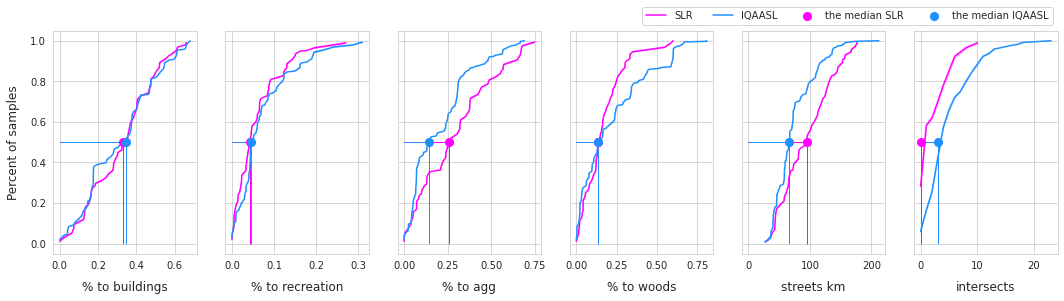

In [4]:
# use only the codes identified in 2017, the protocol only called for certain MLW codes
df = combined_data[combined_data.code.isin(these_codes)].copy()

# scale the streets value
df['streets km'] = df.streets/1000

# a common aggregation
agg_pcs_quantity = {unit_label:'sum', 'quantity':'sum'}

# referene columns
use_these_cols = ['survey year','loc_date' ,'% to buildings', '% to trans', '% to recreation', '% to agg', '% to woods','population','water_name_slug','streets km', 'intersects', 'groupname','code']

# !!walensee landuse is approximated by comparing the land use profile from similar locations!!
# the classification for that part of switzerland is incomplete for the current estimates
# the previous one is 15 years old
# the land use profile of wychely - brienzersee was used for walenstadt-wyss (more prairie, buildings less woods)
# the land use profile of grand-clos - lac-leman was used for other locations on walensee (more woods, less buildings, less praire and agg)
luse_wstdt = dfBeaches.loc['wycheley'][['population','% to buildings', '% to trans', '% to recreation', '% to agg', '% to woods']]
estimate_luse = dfBeaches.loc['grand-clos'][['population','% to buildings', '% to trans', '% to recreation', '% to agg', '% to woods']]

# seperate out the locations that aren't walenstadt
wlsnsee_locs_not_wstdt = ['gasi-strand', 'untertenzen', 'mols-rocks', 'seeflechsen', 'seemuhlestrasse-strand', 'muhlehorn-dorf', 'murg-bad', 'flibach-river-right-bank']

for a_param in estimate_luse.index:
    df.loc[df.location.isin(wlsnsee_locs_not_wstdt), a_param] = estimate_luse[a_param]
    df.loc['walensee_walenstadt_wysse', a_param] = luse_wstdt[a_param]
    
dfdt = df.groupby(use_these_cols[:-2], as_index=False).agg(agg_pcs_quantity)

# explanatory variables:
luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']

# chart the distribtuion of survey results with respect to the land use profile
fig, axs = plt.subplots(1, len(luse_exp), figsize=(len(luse_exp)*3,4), sharey='row')

data=dfdt[(dfdt['survey year'] == '2018')].groupby(use_these_cols[:-2], as_index=False).agg({'p/100m':'sum', 'quantity':'sum'})
data2=dfdt[(dfdt['survey year'] == '2020')].groupby(use_these_cols[:-2], as_index=False).agg({'p/100m':'sum', 'quantity':'sum'})

for i, n in enumerate(luse_exp):
    ax=axs[i]
    
    # land use data for each project
    the_data = ECDF(data[n].values)       
    the_data2 = ECDF(data2[n].values)
    
    # the median value    
    the_median = np.median(data[n].values)
    median_two = np.median(data2[n].values)    
    
    # plot the curves
    sns.lineplot(x= the_data.x, y=the_data.y, ax=ax, color='magenta', label="SLR")
    sns.lineplot(x=the_data2.x, y=the_data2.y, ax=ax, color='dodgerblue', label="IQAASL")
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 0.5, color='magenta',s=50, linewidth=2, zorder=100, label="the median SLR")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color='magenta', linewidth=1)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color='magenta', linewidth=1)
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([median_two], 0.5, color='dodgerblue',s=50, linewidth=2, zorder=100, label="the median IQAASL")
    ax.vlines(x=median_two, ymin=0, ymax=0.5, color='dodgerblue', linewidth=1)
    ax.hlines(xmax=median_two, xmin=0, y=0.5, color='dodgerblue', linewidth=1)
    if i == 0:
        ax.get_legend().remove()
        ax.set_ylabel("Percent of samples", **ck.xlab_k)
    else:
        ax.get_legend().remove()
    ax.set_xlabel(n, **ck.xlab_k)
    
handles, labels=ax.get_legend_handles_labels()

plt.subplots_adjust(top=.9)
fig.legend(handles, labels, bbox_to_anchor=(.9,1), loc='upper right', ncol=4)

plt.show()

*Distribution of number of surveys with respect to land use profile SLR - IQAASL* 

The sample locations in the SLR had a greater percent of land attributed to aggriculture and a more dense road network compared to locations in IQAASL. The percent of land attributed to woods diverges after the median at which point the locations in IQAASL had a greater percentage of land attributed to woods compared to SLR.

The population (not shown) is taken from statpop 2018 {cite}`statpop`. The smallest population was 442 and the largest was 415,357. At least 50% of the samples came from municipalities with a population of $\approx$ 13,000 or less.

If percent of land use attributed to agriculture is a sign of urbanization then the survey areas in 2020 were slightly more urban than 2018. 

## Results lakes and rivers

Considering only the lakes and rivers that have samples in both years there were more samples and more trash was collected from fewer locations in 2018 than 2020. However, on a pieces per meter basis the mean, median and maximum were all higher in 2020.

### Distribution of results 2018 and 2020

*__Top Left:__ survey totals by date, __Top right:__ median monthly survey total* 

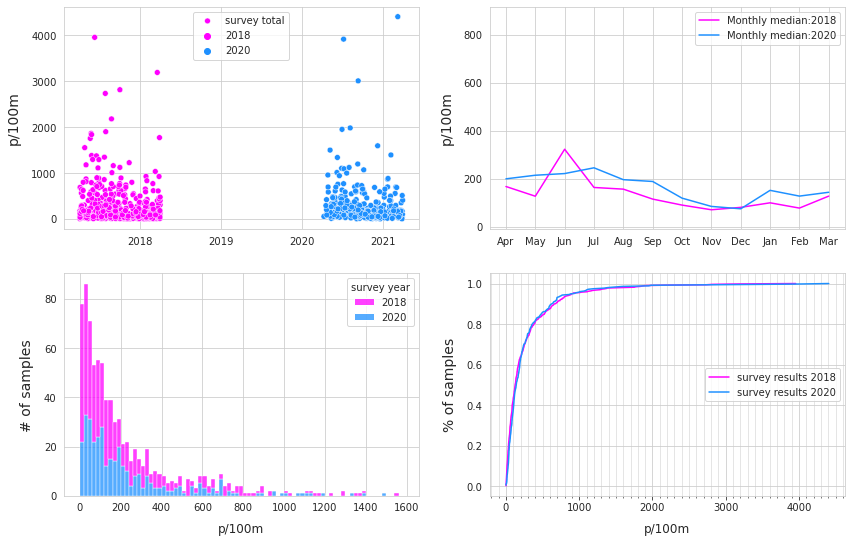

In [5]:
# group by survey and sum all the objects for each survey AKA: survey total
data=df.groupby(['survey year','loc_date', 'date'], as_index=False)[unit_label].sum()

# get the ecdf for both projects
ecdf_2017 = ECDF(data[data['survey year'] == '2018'][unit_label].values)
ecdf_2020 = ECDF(data[data['survey year'] == '2020'][unit_label].values)

# convenience func and dict to display table values
change_names = {'count':'# samples', 'mean':F"average {unit_label}", 'std':'standard deviation', 'min':F"min {unit_label}",  '25%':'25%',  '50%':'50%', '75%':'75%', 'max':F"max {unit_label}", 'min':'min p/100', 'total objects':'total objects', '# locations':'# locations', 'survey year':'survey year'}

# group by survey year and use pd.describe to get basic stats
som_1720 = data.groupby('survey year')[unit_label].describe().round(2)

# add total quantity and number of unique locations
som_1720['total objects'] = som_1720.index.map(lambda x: df[df['survey year'] == x].quantity.sum())
som_1720['# locations'] = som_1720.index.map(lambda x: df[df['survey year'] == x].location.nunique())

# make columns names more descriptive
som_1720.rename(columns=(change_names), inplace=True)
ab = som_1720.reset_index()

# melt that on survey year
c_s = ab.melt(id_vars=['survey year'])

# pivot on survey year
combined_summary = c_s.pivot(columns='survey year', index='variable', values='value').reset_index()

# format for printing
combined_summary['2018'] = combined_summary['2018'].map(lambda x: F"{int(x):,}")
combined_summary['2020'] = combined_summary['2020'].map(lambda x: F"{int(x):,}")

# change the index to date
data.set_index('date', inplace=True)

# get the median monthly value
monthly_2017 = data.loc[data['survey year'] == '2018']['p/100m'].resample('M').median()
# change the date to the name of the month for charting
months_2017 = pd.DataFrame({'month':[dt.datetime.strftime(x, "%b") for x in monthly_2017.index], unit_label:monthly_2017.values})

# repeat for 2020
monthly_2020 = data.loc[data['survey year'] == '2020']['p/100m'].resample('M').median()
months_2020 = pd.DataFrame({'month':[dt.datetime.strftime(x, "%b") for x in monthly_2020.index], unit_label:monthly_2020.values})

# set the date intervals for the chart
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
years = mdates.YearLocator()

# set a y limit axis:
the_90th = np.percentile(data['p/100m'], 95)

# chart that
fig, ax = plt.subplots(2,2, figsize=(14,9), sharey=False)

# set axs and lables
axone=ax[0,0]
axtwo = ax[0,1]
axthree = ax[1,0]
axfour = ax[1,1]

axone.set_ylabel(unit_label, **ck.xlab_k14)
axone.xaxis.set_minor_locator(months)
axone.xaxis.set_major_locator(years)
axone.set_xlabel(" ")

axtwo.set_xlabel(" ")
axtwo.set_ylabel(unit_label, **ck.xlab_k14)
axtwo.set_ylim(-10, the_90th)

axthree.set_ylabel("# of samples", **ck.xlab_k14)
axthree.set_xlabel(unit_label, **ck.xlab_k)

axfour.set_ylabel("% of samples", **ck.xlab_k14)
axfour.set_xlabel(unit_label, **ck.xlab_k)

# histogram data:
data_long = pd.melt(data[['survey year', 'loc_date', unit_label]],id_vars=["survey year","loc_date"], value_vars=(unit_label,), value_name="survey total")
data_long['year_bin'] = np.where(data_long['survey year'] == '2018', 0, 1)

# scatter plot of surveys both years
sns.scatterplot(data=data, x='date', y='p/100m', color='red', s=34, ec='white',label="survey total", hue='survey year', palette= this_palette, ax=axone)
axone.legend(loc='upper center')

# monthly median
sns.lineplot(data=months_2017, x='month', y=unit_label, color='magenta', label=F"Monthly median:2018", ax=axtwo)
sns.lineplot(data=months_2020, x='month', y=unit_label, color='dodgerblue', label=F"Monthly median:2020", ax=axtwo)

# histogram
sns.histplot(data=data_long, x='survey total', hue='survey year', stat='count', multiple='stack',palette=this_palette, ax=axthree, bins=[x*20 for x in np.arange(80)])

# empirical cumulative distribution
sns.lineplot(x=ecdf_2017.x, y=ecdf_2017.y, ax=axfour, color='magenta', label="survey results 2018")
sns.lineplot(x=ecdf_2020.x, y=ecdf_2020.y, ax=axfour, color='dodgerblue', label="survey results 2020")

axfour.xaxis.set_major_locator(ticker.MultipleLocator(1000)) 
axfour.xaxis.set_minor_locator(ticker.MultipleLocator(100)) 

axfour.legend(loc="center right")
axfour.tick_params(which="both", bottom=True)
axfour.grid(b=True, which='minor',linewidth=0.5)

plt.show()

*__bottom Left:__ number of samples with respect to the survey total, __bottom right:__ empirical cumulative distribution of survey totals* 

### Summary data and material types 2018 and 2020

*__Left:__ summary of survey totals, __right:__ material type*

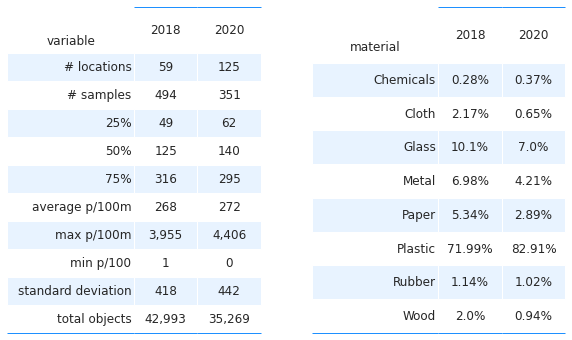

In [6]:
# material totals
mat_total = df.groupby(['survey year', 'code'], as_index=False).quantity.sum()

# add material type:
mat_total['mat'] = mat_total.code.map(lambda x:code_material_map.loc[x])

# the most common codes for each year
mat_total = mat_total.groupby(['survey year', 'mat'], as_index=False).quantity.sum()

# get the % of total and fail rate for each object from each year
# add the yearly total column
mat_total.loc[mat_total['survey year'] == '2018', 'yt'] = mat_total[mat_total['survey year'] == '2018'].quantity.sum()
mat_total.loc[mat_total['survey year'] == '2020', 'yt'] = mat_total[mat_total['survey year'] == '2020'].quantity.sum()

# get % of total
mat_total['pt'] =((mat_total.quantity/mat_total.yt)*100).round(2)

# format for printing:
mat_total['pt'] = mat_total.pt.map(lambda x: F"{x}%")
mat_total['quantity'] = mat_total.quantity.map(lambda x: F"{x:,}")

# pivot and rename columns
m_t = mat_total[['survey year','mat', 'quantity', 'pt']].pivot(columns='survey year', index='mat', values='pt').reset_index()
m_t.rename(columns={'mat':'material', 'pt':'% of total'}, inplace=True)

# put that in a table
fig, axs = plt.subplots(1, 2, figsize=(10,6))

axone = axs[0]
axtwo= axs[1]

# convenience func
ut.hide_spines_ticks_grids(axone)
ut.hide_spines_ticks_grids(axtwo)

# summary data table
a_table = axone.table(cellText=combined_summary.values,  colLabels=combined_summary.columns, colWidths=[.5,.25,.25], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,combined_summary,combined_summary.columns, s_et_bottom_row=True)

# material totals
a_table = axtwo.table(cellText=m_t.values,  colLabels=m_t.columns, colWidths=[.5,.25,.25], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,m_t,m_t.columns, s_et_bottom_row=True)

plt.show()

*Chemicals refers to parafin wax and wood refers to treated or wood shaped for use*

#### Difference of medians 2018 - 2020: survey totals

The observed difference of medians between the two projects is 15p/100m, differences of this magnitude may not be percieved by the casual observer or may not even be significant. A permutation test was conducted to test the hypothesis:

*Null hypothesis:* The median of the survey results from 2018 and 2020 are not statistically different. The observed difference is due to chance.

*Alternate hypothesis:* The median of the survey results from 2018 is not the same as the survey results from 2020. The observed difference in the samples is significant.

The survey results were resampled 5,000 times and shuffled on the survey year column.

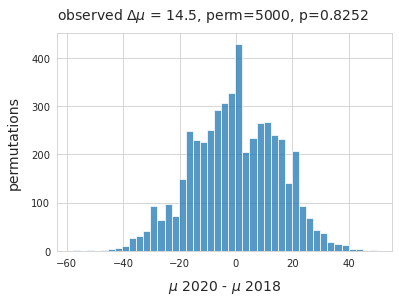

In [7]:
# data for testing
data=df.copy()

# get the survey total for each survey keep the survey year column
pre_shuffle = data.groupby(['survey year', 'loc_date'], as_index=False)[unit_label].sum()

# get the mean from each year
observed_mean = pre_shuffle.groupby('survey year')[unit_label].median()

# get the dif mu_2020 - mu_2017
observed_dif = observed_mean.loc["2020"] - observed_mean.loc["2018"]

# a place to store the sample statistics
new_means=[]

# resampling:
for element in np.arange(5000):
    
    # shuffle the entire survey year column
    pre_shuffle['new_class'] = pre_shuffle['survey year'].sample(frac=1).values
    # get the mean for both 'survey years'
    b=pre_shuffle.groupby('new_class').median()
    # get the change and store it    
    new_means.append((b.loc['2018'] - b.loc['2020']).values[0])

# calculate the empirical p
emp_p = np.count_nonzero(new_means <= observed_dif )/ 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"observed $\u0394\mu$ = {np.round(observed_dif, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel("$\mu$ 2020 - $\mu$ 2018", **ck.xlab_k14)
plt.show()


*Difference of median survey totals 2020 - 2018: refuse to reject the null hypothesis that the observed difference is due to chance*

### The most common objects

The most common objects are any object that was found in at least 50% of all the surveys or whose total quantity is in the top ten of all objects. This accounts for 60% - 80% of all objects found. The most common objects are not the same year over year.

*Glass pieces > 2.5cm* made the list in 2018 and *glass bottles* made the list in 2020.

*__Left:__ most common objects 2018, __right:__ most common objects 2020* 

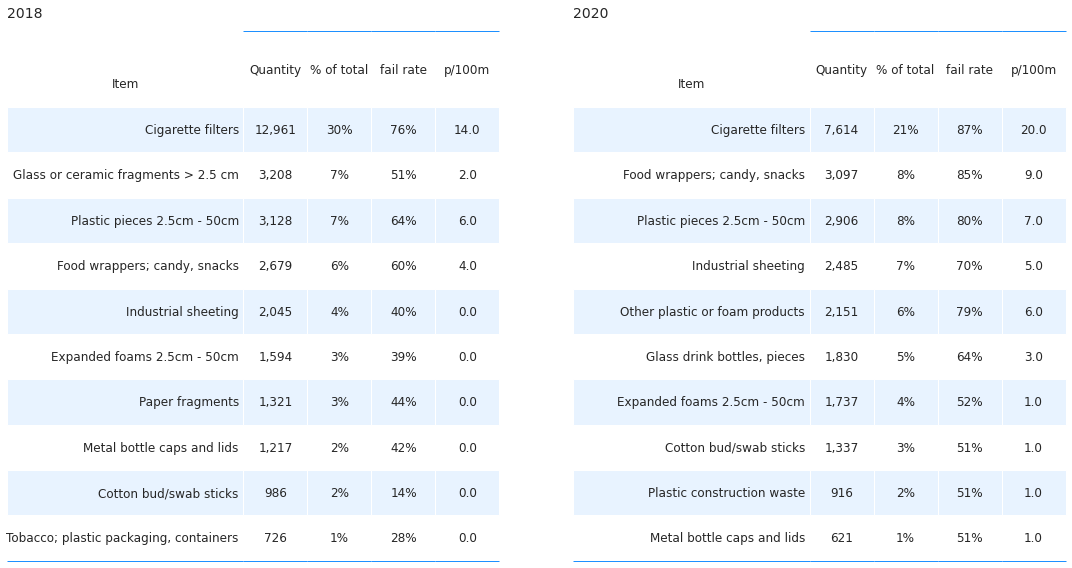

In [8]:
# code totals by project
c_totals = df.groupby(['survey year', 'code'], as_index=False).agg({'quantity':'sum', 'fail':'sum', unit_label:'median'})

# calculate the fail rate % of total for each code and survey year
for a_year in ["2018", "2020"]:
    c_totals.loc[c_totals['survey year'] == a_year, 'fail rate'] = ((c_totals.fail/df[df['survey year'] == a_year].loc_date.nunique())*100).astype('int')
    c_totals.loc[c_totals['survey year'] == a_year, '% of total'] = ((c_totals.quantity/df[df['survey year'] == a_year].quantity.sum())*100).astype('int')
    
# get all the instances where the fail rate is > .4999
c_50 = c_totals.loc[c_totals['fail rate'] > 49.99]

# the top ten from each project
ten_2017 = c_totals[c_totals['survey year'] == '2018'].sort_values(by='quantity', ascending=False)[:10].code.unique()
ten_2020 = c_totals[c_totals['survey year'] == '2020'].sort_values(by='quantity', ascending=False)[:10].code.unique()

# combine the most common from each year with the top ten from each year
# most common 2017
mcom_2017 = list(set(c_50[c_50['survey year']=='2018'].code.unique())|set(ten_2017))

# most common 2020
mcom_2020 = list(set(c_50[c_50['survey year']=='2020'].code.unique())|set(ten_2020))

# get the data
com_2017 = c_totals[(c_totals['survey year'] == '2018')&(c_totals.code.isin(mcom_2017))]
com_2020 = c_totals[(c_totals['survey year'] == '2020')&(c_totals.code.isin(mcom_2020))]

# format values for table
table_data = []
chart_labels = ['2018', '2020']
for i, som_data in enumerate([com_2017, com_2020]):
    som_data = som_data.set_index('code')
    som_data.sort_values(by='quantity', ascending=False, inplace=True)
    som_data['item'] = som_data.index.map(lambda x: code_description_map.loc[x])
    som_data['% of total'] = som_data["% of total"].map(lambda x: F"{int(x)}%")
    som_data['quantity'] = som_data.quantity.map(lambda x: F"{int(x):,}")
    som_data['fail rate'] = som_data['fail rate'].map(lambda x: F"{int(x)}%")
    som_data[unit_label] = som_data[unit_label].map(lambda x: F"{round(x,2)}")    
    table_data.append({chart_labels[i]:som_data})

# the columns needed
cols_to_use = {'item':'Item','quantity':'Quantity', '% of total':'% of total', 'fail rate':'fail rate', unit_label:unit_label}

fig, axs = plt.subplots(1,2, figsize=(15,10*.8))

for i,this_table in enumerate(table_data):
    this_ax = axs[i]
    this_ax.set_title(chart_labels[i], **ck.title_k14)
    ut.hide_spines_ticks_grids(this_ax)
    the_first_table_data = this_ax.table(table_data[i][chart_labels[i]][cols_to_use.keys()].values,  colLabels=list(cols_to_use.values()), colWidths=[.48, .13,.13,.13, .13], bbox=[0, 0, 1, 1])
    a_summary_table_one = sut.make_a_summary_table(the_first_table_data,table_data[i][chart_labels[i]][cols_to_use.keys()].values,list(cols_to_use.values()), 'dodgerblue')

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.show()

plt.close()

*Six of the ten most common objects in 2018 have a fail rate < 50% versus none in 2020* 

#### Difference of means: most common objects

There are significant differences in the median survey result of the most common objects from one project to the next. The results from 2018 suggest there are alot of surveys that have a value of zero for the most common objects. To evaluate the statisitical siginificance of the results for specfic objects between projects a permutation test was conducted to test the two following conditions for each of the most common codes:

__Test one:__ 

*Null hypothesis:* The mean of the of the survey results of the most common objects from 2018 is the same as 2020. The observed difference is due to chance.

*Alternate hypothesis:* The mean of the survey results of the most common objects from 2018 is different than 2020. The observed difference in the samples is significant.

__Test two:__ 

*Null hypothesis:* The mean of the survey results of the most common objects from 2018 is less than 2020. The observed difference is due to chance.

*Alternate hypothesis:* The mean of the survey results of the most common objects from 2018  is greater than than 2020. The observed difference in the samples is significant.

__Key:__

* if p and invp > 0.05 = white: there is no evidence to support the alternate hypothesis
* if p or invp < 0.05 = red: the difference is statistically significant and positive
* if p or invp < 0.05 = yellow: the difference is statistically significant and negative

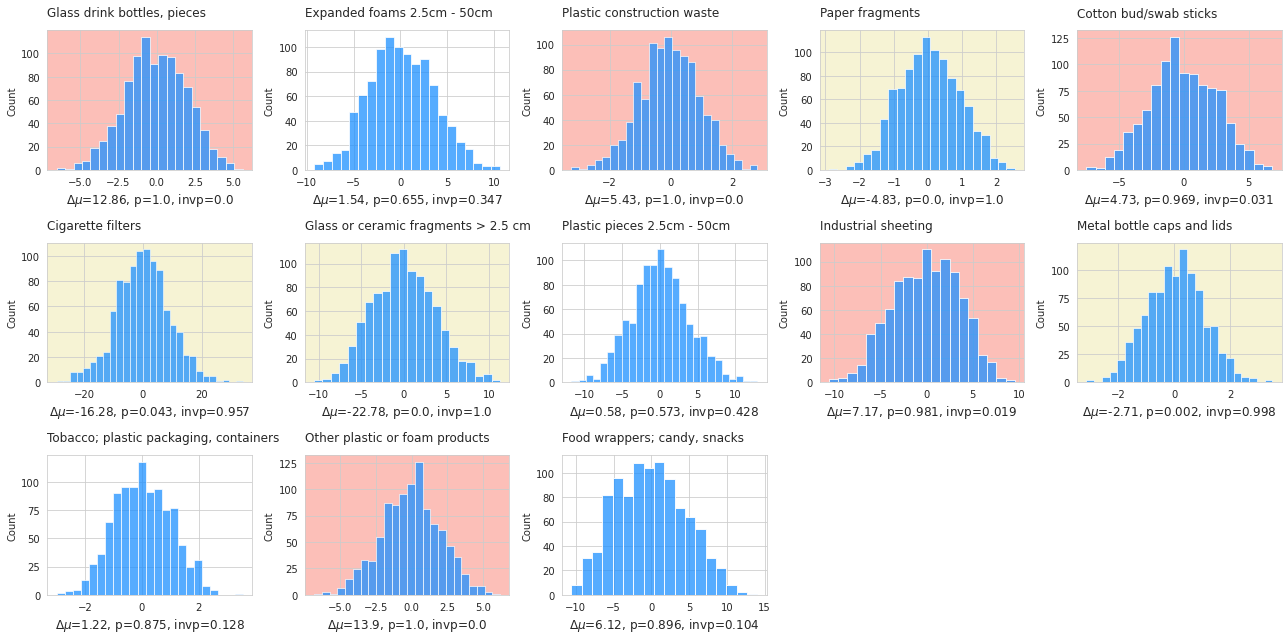

In [9]:
# data for permutation testing
data=df.copy()

# the most common codes from both projects
common_codes_both_years = list(set([*mcom_2017, *mcom_2020]))

# data to resample
pre_shuffle = data[data.code.isin(common_codes_both_years)].groupby(['survey year', 'loc_date', 'code'], as_index=False)[unit_label].sum()

# the mean by survey year
observed_mean = pre_shuffle.groupby(['survey year', 'code'])[unit_label].mean()

# get the differences from one year to the next: check the inverse condtion
observed_dif = observed_mean.loc["2020"] - observed_mean.loc["2018"]
inv_diff = observed_mean.loc["2018"] - observed_mean.loc["2020"]

# how many permutations
perms = 1000

# keep the test statisitcs here
new_means=[]

# permutation resampling:
for a_code in common_codes_both_years:
    
    # hypothese one
    cdif = []    
    # hypothesis two
    invdif=[]
    
    # get the data for the code
    c_data = pre_shuffle[pre_shuffle.code == a_code].copy()
    
    # shuffle
    for element in np.arange(perms):
        # creating new column for shuffled survey years
        c_data['new_class'] = c_data['survey year'].sample(frac=1).values
        # get the mean
        b=c_data.groupby('new_class').mean()
        # h1
        cdif.append((b.loc['2020'] - b.loc['2018']).values[0])
        # h2
        invdif.append((b.loc['2018'] - b.loc['2020']).values[0])
    # calculate p
    emp_p = np.count_nonzero(cdif <= (observed_dif.loc[a_code])) / perms
    inv_p = np.count_nonzero(invdif <= (inv_diff.loc[a_code])) / perms
    
    # store that result
    if inv_p < 0.05:
        new_means.append({a_code:{'p':emp_p, 'invp':inv_p, 'difs':invdif}})
    else:
        new_means.append({a_code:{'p':emp_p, 'invp':inv_p, 'difs':cdif}})

# chart the results
fig, axs = plt.subplots(3,5, figsize=(18,9))

for i,code in enumerate(common_codes_both_years):
    
    # assign columns and rows
    row = int(np.floor((i/5)%5))
    col =i%5
    ax=axs[row, col]
    
    # the data to plot
    data = new_means[i][code]['difs']
    p=new_means[i][code]['p']
    invp=new_means[i][code]['invp']
    
    # set the face color according to p
    if invp < 0.05:
        ax.patch.set_facecolor('salmon')
        ax.patch.set_alpha(0.5)
    if p < 0.05:
        ax.patch.set_facecolor('palegoldenrod')
        ax.patch.set_alpha(0.5)        
     
    # plot that
    sns.histplot(data, ax=ax, color='dodgerblue')
 
    ax.set_title(code_description_map.loc[code], **ck.title_k)
    ax.set_xlabel(F"$\u0394\mu$={np.round(observed_dif.loc[code], 2)}, p={new_means[i][code]['p']}, invp={new_means[i][code]['invp']}", fontsize=12)

ut.hide_spines_ticks_grids(axs[2,3])
ut.hide_spines_ticks_grids(axs[2,4])

plt.subplots_adjust(hspace=0.25)
plt.tight_layout()

plt.show()

## Results lakes 2018 and 2020
The following lakes were sampled in both project years:

1. Zurichsee
2. Bielersee
3. Neuenburgersee
4. Walensee
5. Lac Léman
6. Thunersee

When just the six lakes are considered there were more samples, more locations and more trash was collected in 2020, but the median and average were both lower with respect to 2018. 

In [10]:
# a df with just the lakes of interest
lks_df = df[df.water_name_slug.isin(these_lakes)].drop_duplicates().copy()

# a month column
lks_df['month'] = lks_df.date.dt.month

# survey totals
lks_dt = lks_df.groupby(['survey year', 'water_name_slug','loc_date','date', 'month'], as_index=False)[unit_label].sum()

# locations in both years
com_locs_df = lks_df[lks_df.location.isin(both_years)].copy()

# nsamps from locations in both years
nsamps_com_locs = com_locs_df[com_locs_df['survey year'] == '2020'].groupby(['location'], as_index=True).loc_date.nunique()

# common locations surveyed in 2020
com_locs_20 = com_locs_df[com_locs_df['survey year'] == '2020'].location.unique()

# locations surveyed in 2020
locs_lakes = lks_df[lks_df['survey year'] == '2020'].location.unique()

### Lakes: distribution of survey totals

*__Top Left:__ survey totals by date, __Top right:__ median monthly survey total* 

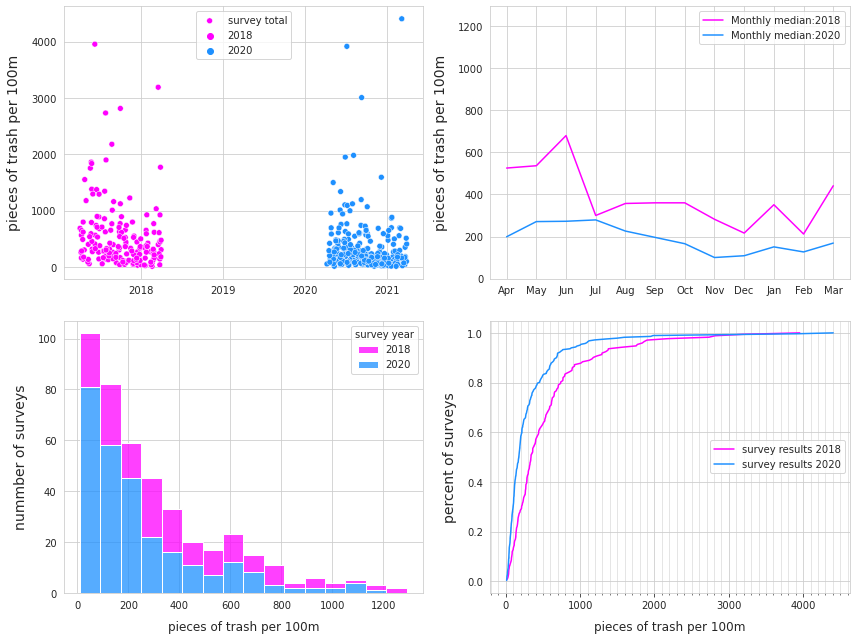

In [11]:
data=lks_df.groupby(['survey year','loc_date', 'date'], as_index=False)[unit_label].sum()
data.set_index('date', inplace=True)

# the empirical distributions for each year
ecdf_2017 = ECDF(data[data['survey year'] == '2018'][unit_label].values)
ecdf_2020 = ECDF(data[data['survey year'] == '2020'][unit_label].values)

# get the x,y vals for each year
ecdf_2017_x, ecdf_2017_y = ecdf_2017.x, ecdf_2017.y
ecdf_2020_x, ecdf_2020_y = ecdf_2020.x, ecdf_2020.y

the_90th = np.percentile(data[unit_label], 95)

# the monthly plots
just_2017 = data[data['survey year'] == '2018'][unit_label].resample('M').median()
monthly_2017 = pd.DataFrame(just_2017)
monthly_2017.reset_index(inplace=True)
monthly_2017['month'] = monthly_2017.date.map(lambda x: dt.datetime.strftime(x, "%b"))

just_2020 = data[data['survey year'] == '2020'][unit_label].resample('M').median()
monthly_2020 = pd.DataFrame(just_2020)
monthly_2020.reset_index(inplace=True)
monthly_2020['month'] = monthly_2020.date.map(lambda x: dt.datetime.strftime(x, "%b"))

# long form data for histogram
data_long = pd.melt(data[['survey year', 'p/100m']],id_vars=["survey year"], value_vars=('p/100m',), value_name="survey total")
data_long['year_bin'] = np.where(data_long['survey year'] == '2018', 0, 1)
data_long = data_long[data_long["survey total"] < the_90th].copy()

fig, ax = plt.subplots(2,2, figsize=(12,9), sharey=False)

# set axs and labels
axone=ax[0,0]
axtwo = ax[0,1]
axthree = ax[1,0]
axfour = ax[1,1]

axone.set_ylabel("pieces of trash per 100m", **ck.xlab_k14)
axone.set_xlabel(" ")

axone.xaxis.set_minor_locator(months)
axone.xaxis.set_major_locator(years)

axtwo.set_xlabel(" ")
axtwo.set_ylabel("pieces of trash per 100m", **ck.xlab_k14)

axthree.set_ylabel("nummber of surveys", **ck.xlab_k14)
axthree.set_xlabel("pieces of trash per 100m", **ck.xlab_k)
axtwo.set_ylim(0, the_90th)

axfour.set_ylabel("percent of surveys", **ck.xlab_k14)
axfour.set_xlabel("pieces of trash per 100m", **ck.xlab_k)

# all samples scatter
sns.scatterplot(data=data, x='date', y=unit_label, color='red', s=34, ec='white',label="survey total", hue='survey year', palette= this_palette, ax=axone)

# monthly medians
sns.lineplot(data=monthly_2017, x='month', y=unit_label, color='magenta', label=F"Monthly median:2018", ax=axtwo)
sns.lineplot(data=monthly_2020, x='month', y=unit_label, color='dodgerblue',label=F"Monthly median:2020",  ax=axtwo)

# histogram of survey results
sns.histplot(data=data_long, x='survey total', hue='survey year', stat='count', multiple='stack', palette=this_palette, ax=axthree)

# ecdfs
sns.lineplot(x=ecdf_2017_x, y=ecdf_2017_y, ax=axfour, color='magenta', label="survey results 2018")
sns.lineplot(x=ecdf_2020_x, y=ecdf_2020_y, ax=axfour, color='dodgerblue', label="survey results 2020")

axfour.xaxis.set_major_locator(ticker.MultipleLocator(1000)) 
axfour.xaxis.set_minor_locator(ticker.MultipleLocator(100)) 
axfour.legend(loc="center right")
axfour.tick_params(which="both", bottom=True)
axfour.grid(b=True, which='minor',linewidth=0.5)

axone.legend(loc='upper center')

plt.tight_layout()
plt.show()

*__bottom Left:__ number of samples with respect to the survey total, __bottom right:__ empirical cumulative distribution of survey totals* 

### Lakes: summary data and material types

*__Left:__ summary of survey totals, __right:__ material type*

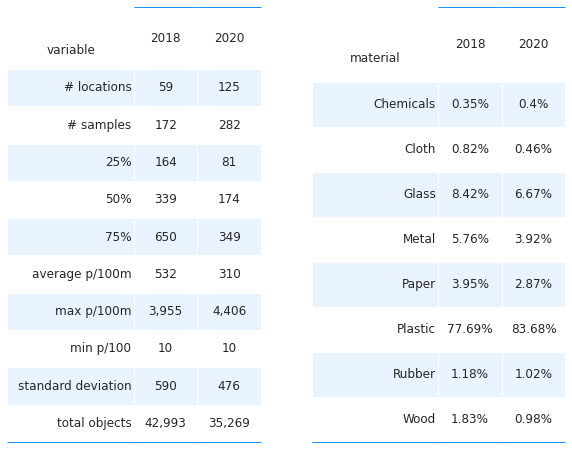

In [12]:
# group by survey year and use pd.describe to get basic stats
som_1720 = lks_dt.groupby('survey year')[unit_label].describe().round(2)

# add total quantity and number of unique locations
som_1720['total objects'] = som_1720.index.map(lambda x: df[df['survey year'] == x].quantity.sum())
som_1720['# locations'] = som_1720.index.map(lambda x: df[df['survey year'] == x].location.nunique())

# make columns names more descriptive
som_1720.rename(columns=(change_names), inplace=True)
ab = som_1720.reset_index()

# melt that on survey year
c_s = ab.melt(id_vars=['survey year'])

# pivot on survey year
combined_summary = c_s.pivot(columns='survey year', index='variable', values='value').reset_index()

# format for printing
combined_summary['2018'] = combined_summary['2018'].map(lambda x: F"{int(x):,}")
combined_summary['2020'] = combined_summary['2020'].map(lambda x: F"{int(x):,}")

# material totals
mat_total = lks_df.groupby(['survey year', 'code'], as_index=False).quantity.sum()

# add material type:
mat_total['mat'] = mat_total.code.map(lambda x:code_material_map.loc[x])

# the most common codes for each year
mat_total = mat_total.groupby(['survey year', 'mat'], as_index=False).quantity.sum()

# get the % of total and fail rate for each object from each year
# add the yearly total column
mat_total.loc[mat_total['survey year'] == '2018', 'yt'] = mat_total[mat_total['survey year'] == '2018'].quantity.sum()
mat_total.loc[mat_total['survey year'] == '2020', 'yt'] = mat_total[mat_total['survey year'] == '2020'].quantity.sum()

# get % of total
mat_total['pt'] =((mat_total.quantity/mat_total.yt)*100).round(2)

# format for printing:
mat_total['pt'] = mat_total.pt.map(lambda x: F"{x}%")
mat_total['quantity'] = mat_total.quantity.map(lambda x: F"{x:,}")

m_t = mat_total[['survey year','mat', 'quantity', 'pt']].pivot(columns='survey year', index='mat', values='pt').reset_index()
m_t.rename(columns={'mat':'material', 'pt':'% of total'}, inplace=True)

# put that in a table
fig, axs = plt.subplots(1, 2, figsize=(10,8))

axone = axs[0]
axtwo= axs[1]

ut.hide_spines_ticks_grids(axone)
ut.hide_spines_ticks_grids(axtwo)

# summary data table
a_table = axone.table(cellText=combined_summary.values,  colLabels=combined_summary.columns, colWidths=[.5,.25,.25], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,combined_summary,combined_summary.columns, s_et_bottom_row=True)

# material totals
a_table = axtwo.table(cellText=m_t.values,  colLabels=m_t.columns, colWidths=[.5,.25,.25], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,m_t,m_t.columns, s_et_bottom_row=True)

plt.show()

### Lakes: results most common objects from 2018

The most common objects were 71% of all objects counted in 2018 versus 60% in 2020.

*Lakes: key indicators of the most common objects 2018 - 2020*

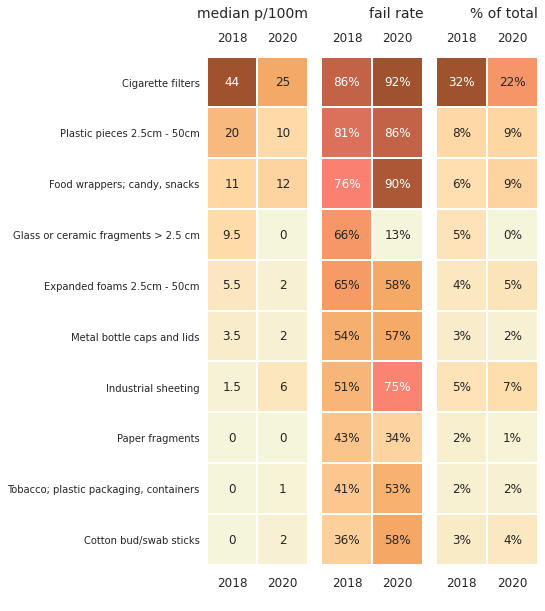

In [13]:
# compare the key indicators of the most common objects
lks_codes = lks_df[lks_df.code.isin(mcom_2017)].copy()
lks_codes = lks_df[lks_df.code.isin(mcom_2017)].groupby(['code', 'survey year'], as_index=False).agg({unit_label:'median', 'quantity':'sum', 'fail':'sum', 'loc_date':'nunique'})

# get fail rate and % of total
for a_year in ['2020', '2018']:
    lks_codes.loc[lks_codes['survey year'] == a_year, 'fail rate'] = lks_codes.fail/lks_df[lks_df['survey year']==a_year].loc_date.nunique()
    lks_codes.loc[lks_codes['survey year'] == a_year, '% of total'] = lks_codes.quantity/lks_df[lks_df['survey year']==a_year].quantity.sum()

# pivot on the survey year column and keep all the values
pivot_2017_2020 = lks_codes.pivot(columns='survey year', values=[unit_label, 'fail rate', '% of total'], index='code')

# map description to code
pivot_2017_2020['Item'] = pivot_2017_2020.index.map(lambda x: code_description_map.loc[x])

# set index and sort
pivot_2017_2020.set_index('Item', inplace=True, drop=True)
pivot_2017_2020.sort_values(by=(unit_label,'2018'), ascending=False, inplace=True)

# plot that
fig = plt.figure(figsize=(8, 12))

# use gridspec to position
spec = GridSpec(ncols=8, nrows=2, figure=fig)
axone = fig.add_subplot(spec[:,1:3])
axtwo = fig.add_subplot(spec[:,3:5])
axthree = fig.add_subplot(spec[:,5:7])

# get an order to assign each ax
an_order = pivot_2017_2020['p/100m'].sort_values(by='2018', ascending=False).index

# index axtwo and and axthree to axone
axtwo_data = pivot_2017_2020['fail rate'].sort_values(by='2018', ascending=False).reindex(an_order)
axthree_data = pivot_2017_2020['% of total'].sort_values(by='2018', ascending=False).reindex(an_order)

# pieces per meter
sns.heatmap(pivot_2017_2020[unit_label], cmap=cmap2, annot=True, annot_kws={'fontsize':12},  ax=axone, square=True, cbar=False, linewidth=.05,  linecolor='white')
axone.tick_params(**dict(labeltop=True, labelbottom=True, pad=12, labelsize=12), **ck.no_xticks)
axone.set_xlabel(" ")
axone.set_title("median p/100m",**ck.title_k14r)

# fail rate
sns.heatmap(pivot_2017_2020['fail rate'], cmap=cmap2, annot=True, annot_kws={'fontsize':12}, fmt='.0%', ax=axtwo, square=True,  cbar=False, linewidth=.05,  linecolor='white')
axtwo.tick_params(**dict(labeltop=True, labelbottom=True, pad=12, labelsize=12), **ck.no_xticks)
axtwo.tick_params(labelleft=False, left=False)
axtwo.set_xlabel(" ")
axtwo.set_title("fail rate", **ck.title_k14r)

# percent of total
sns.heatmap(pivot_2017_2020['% of total'], cmap=cmap2, annot=True, annot_kws={'fontsize':12}, fmt='.0%', ax=axthree, square=True,  cbar=False, linewidth=.05,  linecolor='white')
axthree.tick_params(**dict(labeltop=True, labelbottom=True, pad=12, labelsize=12), **ck.no_xticks)
axthree.tick_params(labelleft=False, left=False)
axthree.set_xlabel(' ')
axthree.set_title("% of total", **ck.title_k14r)

for anax in [axone, axtwo, axthree]:
    anax.set_ylabel("")

plt.subplots_adjust(wspace=0.3)

plt.show()

### Lakes monthly median common objects: 

All lakes were sampled in all months in both projects. In 2018 the minimum samples per month  was 12 and the maximum was 17 compared to a minimum of 17 and max of 34 in 2020.

*Lakes 2018: monthly average survey result most common objects*

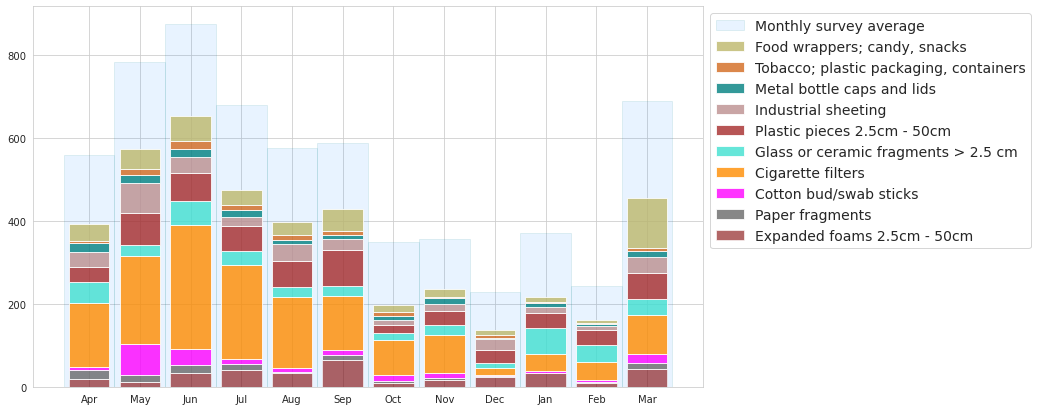

In [14]:
# plot the monthly medidan results for the most common objects
# the code for 2020 is hidden just because it is redundant to see
# slice by survey year
top_ten_month = lks_df[(lks_df['survey year'] == '2018')&(lks_df.code.isin(mcom_2017))].groupby(['loc_date', 'date', 'code'], as_index=False)[unit_label].sum()
top_ten_month['month'] = top_ten_month.date.dt.month

# copy to work on
dts_date = top_ten_month.copy()
dts_date.set_index('date', inplace=True)

# codes to chart
group_names =  mcom_2017

# a dict to manage all the plots
mgr = {}

# for each of the most common codes resample by month and get the average
for a_group in group_names:
    a_plot = dts_date[(dts_date.code==a_group)][unit_label].resample('M').mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

# some colors for all the codes
colors_palette = {
    'G156':'dimgray',
    'G178': 'teal',
    'G177': 'darkslategray',
    'G200': 'lightseagreen',
    'G27':'darkorange',
    'G30':'darkkhaki',
    'G67':'rosybrown',
    'G89': 'salmon',
    'G95':'magenta',
    'G82': 'maroon',
    'G79':'brown',
    'G208': 'turquoise',
    'G124':'indigo',
    'G25': 'chocolate',
    'G31': 'goldenrod',
    'G21': 'tan',
    'G198':'teal',
    'G204':'plum'
}

# label the axs
months={
    0:'Jan',
    1:'Feb',
    2:'Mar',
    3:'Apr',
    4:'May',
    5:'Jun',
    6:'Jul',
    7:'Aug',
    8:'Sep',
    9:'Oct',
    10:'Nov',
    11:'Dec'
}

# plot that
fig, ax = plt.subplots(figsize=(12,7))

def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

# set the bottom of the bar plots
bottom = [0]*len(mgr['G27'])

# average daily total monthly sets the backdrop of the chart
mt = lks_df[lks_df['survey year'] == '2018'].groupby(['loc_date', 'date'], as_index=False).agg({unit_label:'sum', 'quantity':'sum'})
mt.set_index('date', inplace=True)
monthly_total = mt[unit_label].resample('M').mean().fillna(0)

# chart that
this_x = [i for i,x in  enumerate(monthly_total.index)]
ax.bar(this_x, monthly_total.to_numpy(), color='dodgerblue', alpha=0.1, linewidth=1, edgecolor='teal', width=1, label="Monthly survey average")

# for each code lay down a box
for i, a_group in enumerate(group_names):       
    
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 )
    # if i is not zero add to the bottom
    else:
        bottom += mgr[group_names[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)

handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# put the handles and labels in the order of the components
new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]
new_labels.insert(0,"Monthly survey average")

handles = [handles[0], *handles[1:][::-1]]
ax.set_title("")
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)    
plt.show()

<br></br>
*Lakes 2020: monthly average survey result most common objects*

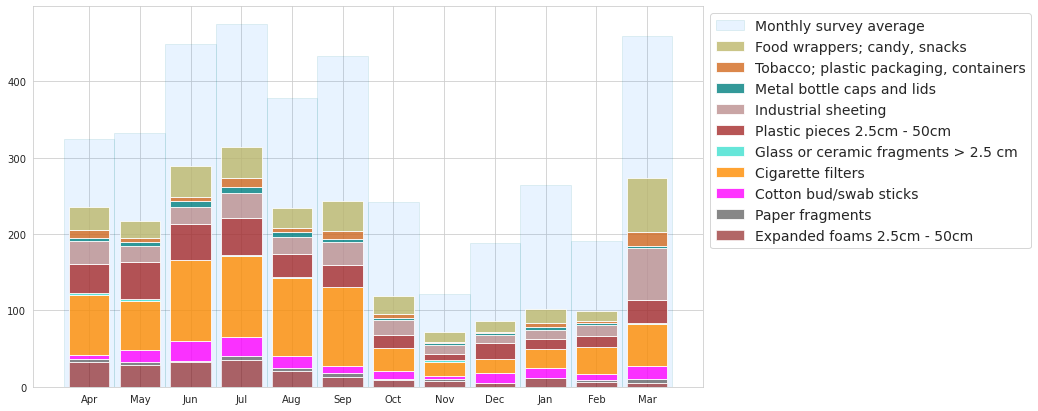

In [15]:
# repeat for 2020
top_ten_month = lks_df[(lks_df['survey year'] == '2020')&(lks_df.code.isin(mcom_2017))].groupby(['loc_date', 'date', 'code'], as_index=False)['p/100m'].sum()
top_ten_month['month'] = top_ten_month.date.dt.month

dts_date = top_ten_month.copy()
dts_date.set_index('date', inplace=True)

mgr2020 = {}

for a_group in group_names:
    a_plot = dts_date[(dts_date.code==a_group)]['p/100m'].resample('M').mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr2020.update(this_group)
fig, ax = plt.subplots(figsize=(12,7))

bottom = [0]*len(mgr2020['G27'])

mt = lks_df[lks_df['survey year'] == '2020'].groupby(['loc_date', 'date'], as_index=False).agg({unit_label:'sum', 'quantity':'sum'})
mt.set_index('date', inplace=True)
monthly_total = mt[unit_label].resample('M').mean().fillna(0)

this_x = [i for i,x in  enumerate(monthly_total.index)]
ax.bar(this_x, monthly_total.to_numpy(), color='dodgerblue', alpha=0.1, linewidth=1, edgecolor='teal', width=1, label="Monthly survey average")

for i, a_group in enumerate(group_names):       
    
    this_x = [i for i,x in  enumerate(mgr2020[a_group].index)]
    this_month = [x.month for i,x in enumerate(mgr2020[a_group].index)]
    
    if i == 0:
        ax.bar(this_x, mgr2020[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6) 
    else:
        bottom += mgr2020[group_names[i-1]].to_numpy()        
        ax.bar(this_x, mgr2020[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)

handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

axisticks = ax.get_xticks()
labelsx = [months[x-1] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]
new_labels.insert(0,"Monthly survey average")

handles = [handles[0], *handles[1:][::-1]]
ax.set_title("", **ck.title_k14)
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)    
plt.show()

### Lakes: A/B testing 2018 - 2020

#### Difference of medians survey totals

When just the lakes are considered the difference of medians is significant. A permutation test was conducted to test the hypothesis:

*Null hypothesis:* The median of the survey results for lakes from 2018 is not statistically different than the median for 2020. The observed difference is due to chance.

*Alternate hypothesis:* The median of the survey results for lakes from 2018 is not the same as the survey results for lakes from 2020. The observed difference in the samples is significant.

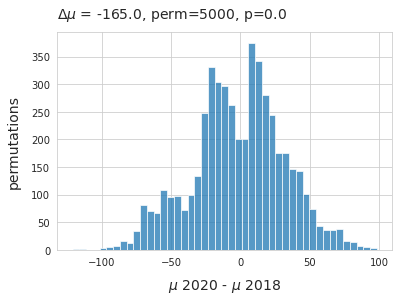

In [16]:
# data for testing
data=df[df.water_name_slug.isin(these_lakes)].copy()

# get the survey total for each survey keep the survey year column
pre_shuffle = data.groupby(['survey year', 'loc_date'], as_index=False)[unit_label].sum()

# get the mean for each survey year
observed_mean = pre_shuffle.groupby('survey year')[unit_label].median()

# get the diff
observed_dif = observed_mean.loc["2020"] - observed_mean.loc["2018"]

new_means=[]
# resampling:
for element in np.arange(5000):
    
    # shuffle the survey year column
    pre_shuffle['new_class'] = pre_shuffle['survey year'].sample(frac=1).values
    # get the means for both years
    b=pre_shuffle.groupby('new_class').median()
    # get the change and store it
    new_means.append((b.loc['2020'] - b.loc['2018']).values[0])

# calculate p
emp_p = np.count_nonzero(new_means <= observed_dif )/ 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(observed_dif, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel("$\mu$ 2020 - $\mu$ 2018", **ck.xlab_k14)
plt.show()


*Lakes difference of mean survey total 2020 -2018: reject the null hypothesis that the observed difference is due to chance*

#### Difference of means most common objects

A permutation test was conducted to test the two following conditions for each of the most common codes:

__Test one:__

*Null hypothesis:* The mean of the of the survey results of the most common objects from 2018 is the same as 2020. The observed difference is due to chance.

*Alternate hypothesis:* The mean of the survey results of the most common objects from 2018 is different than 2020. The observed difference in the samples is significant.

__Test two:__

*Null hypothesis:* The mean of the survey results of the most common objects from 2018 is not greater than or less than 2020. The observed difference is due to chance.

*Alternate hypothesis:* The mean of the survey results of the most common objects from 2018  is greater than or less than 2020. The observed difference in the samples is significant.

__Key:__

* if p and invp > 0.05 = white: there is no evidence to support the alternate hypothesis
* if p or invp < 0.05 = red: the difference is significant and positive
* if p or invp < 0.05 = yellow: the difference is significant and negative

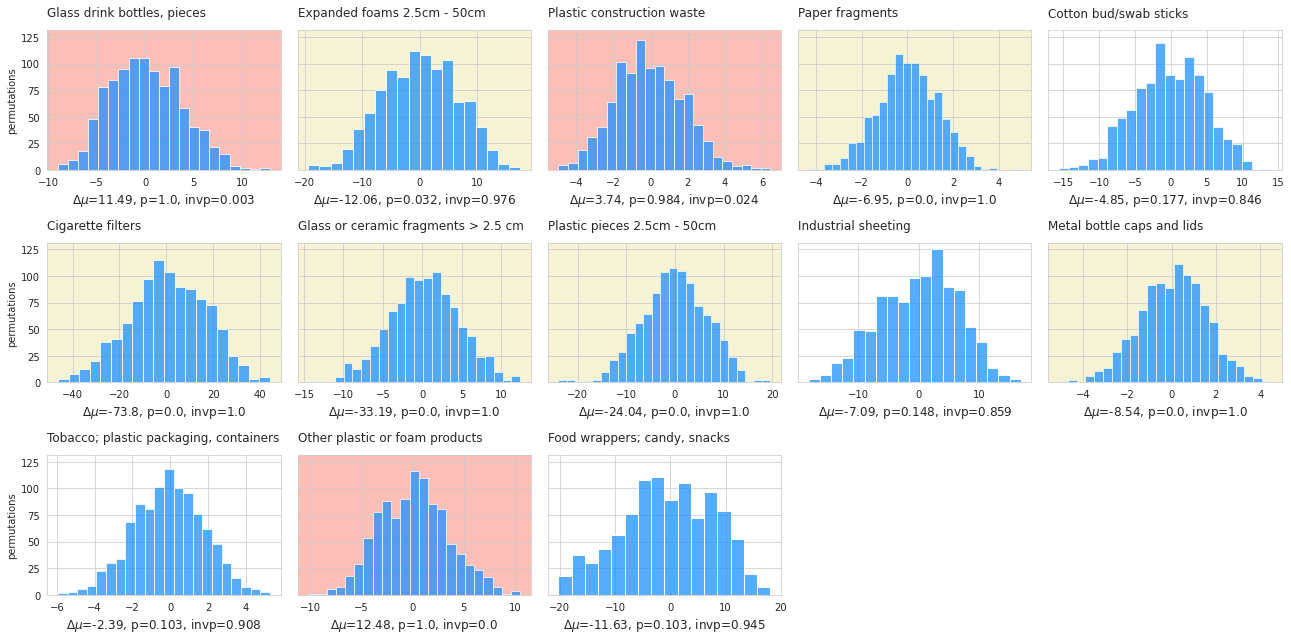

In [17]:
# data testing
data=df[df.water_name_slug.isin(these_lakes)].copy()

# the common codes from both years
common_codes_both_years = list(set([*mcom_2017, *mcom_2020]))

# data to resample
pre_shuffle = data[data.code.isin(common_codes_both_years)].groupby(['survey year', 'loc_date', 'code'], as_index=False)[unit_label].sum()

# the observed mean from each year
observed_mean = pre_shuffle.groupby(['survey year', 'code'])[unit_label].mean()

# get the differences from one year to the next: check the inverse
observed_dif = observed_mean.loc["2020"] - observed_mean.loc["2018"]
inv_diff = observed_mean.loc["2018"] - observed_mean.loc["2020"]

# number of shuffles
perms = 1000

new_means=[]
# resample
for a_code in common_codes_both_years:
    
    # store the test statisitc
    cdif = []
    invdif=[]
    
    # code data
    c_data = pre_shuffle[pre_shuffle.code == a_code].copy()
    for element in np.arange(perms):
        # shuffle labels
        c_data['new_class'] = c_data['survey year'].sample(frac=1).values
        b=c_data.groupby('new_class').mean()
        cdif.append((b.loc['2020'] - b.loc['2018']).values[0])
        invdif.append((b.loc['2018'] - b.loc['2020']).values[0])
    
    # calculate p
    emp_p = np.count_nonzero(cdif <= (observed_dif.loc[a_code])) / perms
    inv_p = np.count_nonzero(invdif >= (observed_dif.loc[a_code])) / perms
    
    # store that result
    if inv_p < 0.05:
        new_means.append({a_code:{'p':emp_p, 'invp':inv_p, 'difs':invdif}})
    else:
        new_means.append({a_code:{'p':emp_p, 'invp':inv_p, 'difs':cdif}})    

# chart the results
fig, axs = plt.subplots(3,5, figsize=(18,9), sharey=True)

for i,code in enumerate(common_codes_both_years):
    
    # set up the ax
    row = int(np.floor((i/5)%5))
    col =i%5
    ax=axs[row, col]
    
    # data for charts
    data = new_means[i][code]['difs']
    
    # pvalues
    p=new_means[i][code]['p']
    invp=new_means[i][code]['invp']
    
    # set the facecolor based on the p value
    if invp < 0.05:
        ax.patch.set_facecolor('salmon')
        ax.patch.set_alpha(0.5)
    if p < 0.05:
        ax.patch.set_facecolor('palegoldenrod')
        ax.patch.set_alpha(0.5)        
    # plot that    
    sns.histplot(data, ax=ax, color='dodgerblue')
    
    ax.set_title(code_description_map.loc[code], **ck.title_k)
    ax.set_xlabel(F"$\u0394\mu$={np.round(observed_dif.loc[code], 2)}, p={new_means[i][code]['p']}, invp={new_means[i][code]['invp']}", fontsize=12)
    ax.set_ylabel('permutations')

# hide the unused axs
ut.hide_spines_ticks_grids(axs[2,3])
ut.hide_spines_ticks_grids(axs[2,4])

# get some space for xaxis label
plt.subplots_adjust(hspace=0.25)

plt.tight_layout()
plt.show()

In [18]:
small = lks_df[lks_df.code.isin([ "G20", "G21", "G22", "G23"])].groupby(['code', 'survey year'], as_index=False).agg({'quantity':'sum', 'p/100m':'mean'})
ttl = combined_data.groupby('survey year').quantity.sum()
small.loc[small['survey year'] == '2018', 'p_t'] = small.quantity/ttl.loc['2018']
small.loc[small['survey year'] == '2020', 'p_t'] = small.quantity/ttl.loc['2020']
# print(small.groupby(['survey year','code']).sum())
# print(small.groupby(['survey year']).sum())

### Land use profile: Spearmans ranked correlation

The land use features were previously calculated to compare the survey locations. To test the statistical significance of land use on beach litter survey results the survey totals and locations from both projects were considered as one group. The survey results of the most common objects were tested against the measured land use features. 

Spearman's $\rho$ or *Spearmans ranked correlation coefficient* is a non parametric test of rank correlation between two variables {cite}`defspearmans` {cite}`spearmansexplained`. The test results are evaluated at p<0.05 and 454 samples, scipy is used to implement the test {cite}`impspearmans`.

1. Red/rose is a postitive association: p<0.05 AND $\rho$ > 0
2. yellow is a negative association: p<0.05 AND $\rho$ < 0
3. white means that p>0.05, there is no statisitical basis to assume an association

An association suggests that survey totals for that object will change in relation to the amount of space attributed to that feature, or in the case of roads or river intersections, the quantity. The magnitude of the relationship is not defined and any association is not linear. 

#### Results of Spearmans $\rho$

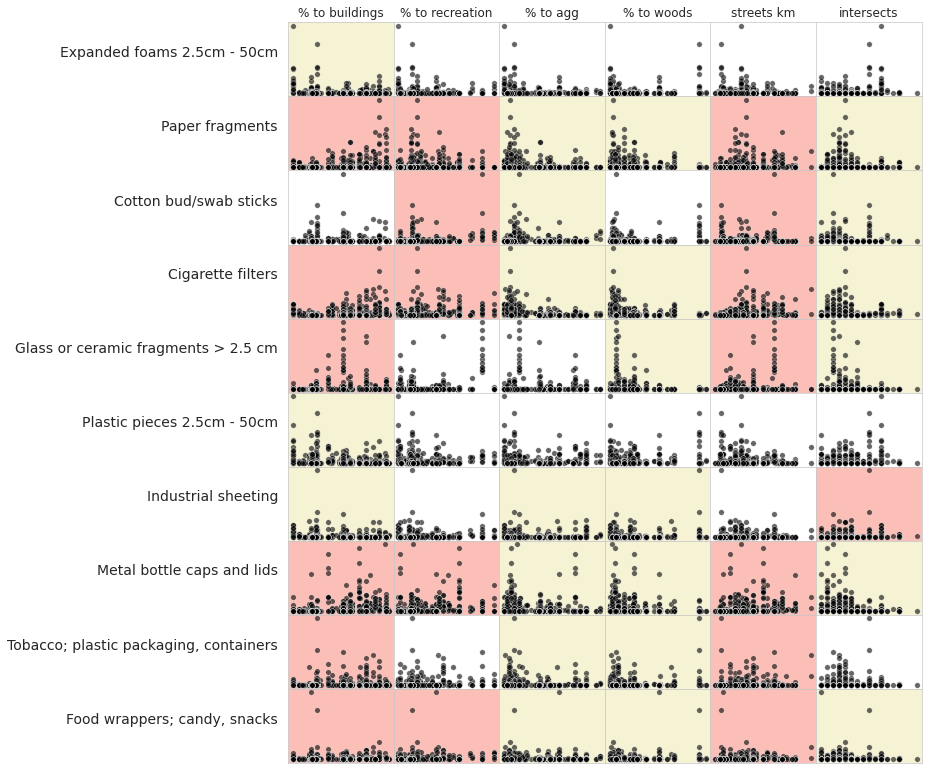

In [19]:
corr_data = lks_df[(lks_df.code.isin(mcom_2017))].copy()

# keys to the column names
some_keys = {
    '% to buildings':'lu_build',
    '% to agg':'lu_agg',
    '% to woods':'lu_woods',
    '% to recreation':'lu_rec',
    '% to trans':'lu_trans',
    '% to meadow':'lu_m',
    'str_rank':'lu_trans'
}

fig, axs = plt.subplots(len(mcom_2017),len(luse_exp), figsize=(len(luse_exp)+7,len(mcom_2017)+1), sharey='row')

for i,code in enumerate(mcom_2017):
    data = corr_data[corr_data.code == code]
    for j, n in enumerate(luse_exp):
        # each grid is its own axis with a scatterplot
        ax=axs[i, j]
        ax.grid(False)
        ax.tick_params(axis='both', which='both',bottom=False,top=False,labelbottom=False, labelleft=False, left=False)
       
        if i == 0:
            ax.set_title(F"{n}")
        else:
            pass
        
        if j == 0:
            ax.set_ylabel(F"{code_description_map[code]}", rotation=0, ha='right', **ck.xlab_k14)
            ax.set_xlabel(" ")
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
        _, corr, a_p = make_plot_with_spearmans(data, ax, n)
        
        # assign the facecolor based on the value of p and rho
        if a_p < 0.05:
            if corr > 0:
                ax.patch.set_facecolor('salmon')
                ax.patch.set_alpha(0.5)
            else:
                ax.patch.set_facecolor('palegoldenrod')
                ax.patch.set_alpha(0.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(F"{project_directory}/test_one.jpg", dpi=300)
plt.show()

#### Interpret Spearmans $\rho$

**Interpreting results for the most common objects** 

A positive association means that the land use attribute or feature had increased survey results when compared to other locations. This may be due to a covariance of attributes, either way **a positive association is a signal that the survey locations are near a zone of accumulation or a source**. This signal should be assessed along with the other key indicators of survey locations that have similar land use profiles. In general locations that fit the criteria could be considered as both a source and an area of accumulation for any objects that are positively associated.

A negative association means that the land use feature or attribute does not facilitate the accumulation of the object. This result is common for aggricultural areas and woods on the national level. **A negative association is a signal that the locations are not a zone of accumulation for the object**.

No or few association means that the land use features had no effect on the accumulation of that object. The survey results of the most common objects with no or few associations fall into two charateristics: 

1. Ubiquitous: high fail rate, high pieces per meter. Found at consistent rates through out the survey area indifferent of land use
2. Transient: low fail rate, high quantity, high pieces per meter, few associations. Found occasionaly in large quantities at specific locations

In [20]:
# get the confidence interval from the slr data
data=df.groupby(['loc_date', 'date', 'survey year'], as_index=False)[unit_label].sum()

data = data[data['survey year'] == '2018']

# get the mean for each survey year
observed_mean = data.groupby('survey year')[unit_label].median()

new_means=[]
# resampling:
for element in np.arange(5000):
    
    less = data[unit_label].sample(n=len(data), replace=True)    
    the_mean = less.median()
    new_means.append(the_mean)
    
# get the upper and lower range of the sample median:
g_25 = np.percentile(new_means, 2.5)
g_975 = np.percentile(new_means, 97.5)

# print the ci, mean and the resample results
# print(g_25, observed_mean[0], g_975)

# chart the results
# fig, ax = plt.subplots()

# sns.histplot(new_means, ax=ax)
# ax.set_title(F"$\u0394\mu$ = {np.round(observed_mean[0], 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
# ax.set_ylabel('permutations', **ck.xlab_k14)
# ax.set_xlabel("$\mu$ 2020 - $\mu$ 2018", **ck.xlab_k14)
# plt.show()

## Discussion

### On balance no change

The summary statistics and the results of the difference of means test imply that there was no statistically measureable change on the national scale from one project to the next. The 95% CI of the median survey total in 2020 was 137 - 188p/100m \( _section [Calculating Baselines](threshhold)_ \). The median result for 2018 was 125p/100m with a CI of 112p/100m to 146p/100m, which includes the lower bound of the median from 2020. __However, the difference of means for the most common objects suggest a more realistic and dyanmic result:__

1. There was a statisitcally significant decrease in litter items associated with behavior:
   * cigarette ends
   * metal bottle caps
   * glass bottles

2. There was a statisitcally significant increase in diffusse items:
   * industrial sheeting
   * plastic construction waste
   * other plastic and foam products
   * cotton swabs
   
The decrease in tobacco and food related products is likely the result of pandemic related restrictions that marked 2020. Increases of industrial sheeting, plastic construction waste and other plastic foam products or cotton swabs (list 2), can not be attributed to a specific event. 

Contrary to food and tobacco products, list 2 objects have few positive associations with land use features or behavior at the survey location \( _section [The land use profile](luseprofile)_ \). Therfore any decrease in litter quantities that are a result of changes in human behavior at the survey site would not be reflected in the quantities of list 2 objects.

These results suggest that perceived local decreasses in litter quantities were most likely the result of a general decline in usage as opposed to a sweeping change in behavior. Consequently the survey results for list 1 items will most likely return to 2018 levels as pandemic related restrictions are relaxed and usage patterns return to _normal_.

When just the lakes are considered there was a significant decrease in the median survey total in 2020. This decrease was led by cigarettes -73p/100m from 2018 - 2020. Other objects on the decline related to consumption at the survey site including _metal bottle tops_ and _paper fragments_.

### Protocols matter

There was a key difference between the two protocols:

* The 2020 protocol counts all visible objects and classifies fragments by size
* The 2018 protocol limited the object counts to items greater than or equal to 2.5cm in length

This difference in protocol effects the interpretation of the results for fragmented plastics and expanded foams from one year to the next.  Expanded foams and fragmented plastics are objects whose original use is unknown but the material can be distinguished. **Fragmented plastics and expanded foams of all sizes are 28% of the total survey results for the lakes in 2020**. Studies in the Meuse/Rhine delta show that these small fragmented objects make up large portions of the total abundance {cite}`meuserhine`.

Allowing surveyors to use a broader range of object codes increases the accuracy of the total survey count and adds levels of differentiation between similar materials. For example, expanded polysytrene is an object that fragments easily. Whether or not surveyors are finding a few larger pieces > 20cm or thousands of pieces < 10mm is an important detail if reducing these objects in the environment is the goal.

__Reduced cost and increased access__ are another result of a harmonized protocol. The procedures used by the SLR and IQAASL were almost identical, with the exception of the size limit it can be assumed that the samples were collected under $\approx$ the same conditions following the same protocol. The SLR data gives the results of over 1,000 observations by $\approx$ 150 people and the IQAASL data gives the results of 350 observations from $\approx$ 10 people. Both methods have weaknessess and strengths that address very diverse topics:

* experience of surveyor
* consistincey of survey results
* oversight
* intended use of data
* allocation of resources

All of these topics should be considered with each project, as well as stewardship of the data. Regardless of the small differences of the two projects __we were able to build on the model proposed by the SLR__ and add to the shared experience. 

### Plastic lids

Plastic lids are separated into three categories during the counting process:

1. drink, food 
2. household cleaners etc..
3. unknown

As a group plastic lids make up 2% of the total objects in 2018 and 3% in 2020. Drink lids were ~51% of all lids found in 2018, 45% in 2020. On a pieces per meter basis there was a decrease in the amount of drink lids and an increase of non-drink lids from 2018 - 2020.
   
### Land use profile

The land use profile for each location was calculated using the same data for both years. When the survey results from both years are considered as a group the results from Spearmans $\rho$ lend support to the SLR conclusions in 2018 that survey results were elevated in urban and suburban environments and that this was also true in 2020. At the same time the ubiquitous nature of _fragmented plastics, industrial sheeting_ and _expanded foams_ noted in the section [_The land use profile_](luseprofile) was most likely prevalent in 2018.

The amount of land attributed to recreational activities are locations near the survey site designed to accomodate groups of people for very different purposes. The positive association of tobacco and food products with this land attribute could be interpreted as the result of temporary increases in population near the survey site.

### Conclusions

The samples from both projects were taken from locations, in some cases the same location, that had similar levels of infrstructure and economic development. A common protocol was used in both projects, the samples were collected by two different groups and managed by two different associations.

From 2018 - 2020 there was a statisitically significant change, decrease, in the amount of objects directly related to behavior at the survey site. This means that any perceived decreases were in locations that had a higher % of land attributed to buildings and lower % of land attributed to aggriculture or woods.

Locations with an opposing or different land use profile (less buildings, more aggriculture or woods) will most likely not have experienced any decrease at all. For locations near river interchanges or major discharge points there would be no perceivable difference from 2018 - 2020 and increases in _fragmented plastics, expanded foams_ and _industrial sheeting_ were likely. Both the test of difference of means of the most common objects and the results from Spearmans $\rho$ of survey results support this conclusion.

Both survey years show peak survey results in June - July and lows in November. The causes for these peaks and troughs are different depending on the object in question. Food and tobacco objects are more prevalent durring the summer season because of increased use. Objects like _fragmented plastics_ depend more on hydrological conditions and the peak discharge rate of the biggest rivers in this study are from May - July (  _section [Shared responsibility](transport)_ ).

Future surveys should include items of all sizes. Data aggregation can be done at the server using defined rules based on known relationships. The total count is a key indicator in all statistics that rely on count data, for modeling purposes it is essential.

In [21]:
author = "roger@hammerdirt.ch"
my_message = "Love what you do. \u2764\ufe0f"
md(F"""
<br></br>
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
""")


<br></br>
**This project was made possible by the Swiss federal office for the environment.**<br>

>Love what you do. ❤️<br>

*roger@hammerdirt.ch* pushed the run button on 2021-10-21.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>


## Annex

### IQAASL surveyors

Hammerdirt staff:

1. Shannon Erismann, field operations manager
2. Helen Kurukulasuriya, surveyor
3. Débora Carmo, surveyor
4. Bettina Siegenthaler, surveyor
5. Roger Erismann, surveyor

Participating organizations:

1. Precious plastic leman
2. Association pour la sauvetage du Léman
3. Geneva international School
4. Solid waste management: École polytechnique fédéral Lausanne

<!-- [annex](#annex)<a id="notes"></a>

#### Notes:

<sup>1</sup> Marine debris in central California: Quantifying type and abundance of beach litter in Monterey Bay, CA. Available from: https://www.researchgate.net/publication/236053935_Marine_debris_in_central_California_Quantifying_type_and_abundance_of_beach_litter_in_Monterey_Bay_CA [accessed Jun 24 2021].

> Marginal heterogeneity was found between different types of litter across month and location. These results indicate litter type is significantly different among months and beach locations(p< 0.01). 

> Because the majority of Styrofoam observed in our surveys was broken-up (5 mm–5 cm), it was nearly impossibleto identify the whole source product from these fragments (i.e.,to-go containers, cups, plates, coolers, and commercial packingmaterial).

<sup>2</sup> S. Miladinova, D. Macias, A. Stips, E. Garcia-Gorriz, Identifying distribution and accumulation patterns of floating marine debris in the Black Sea, Marine Pollution Bulletin, Volume 153, 2020,110964,
ISSN 0025-326X,https://doi.org/10.1016/j.marpolbul.2020.110964. (https://www.sciencedirect.com/science/article/pii/S0025326X20300825)

> Snowmelt and heavy rainfall during this period are thought to be key factors in carrying litter to the sea, as river discharge in this area is usually low at other times of the year.

> Monitoring of marine litter along the Bulgarian Black Sea coast (Simeonova et al., 2018) shows that the beaches are highly polluted due to local sources, where cigarette butts and filters (OSPAR-code 64) are dominant. Since the highest marine litter accumulation is observed in summer, one can conclude that the accumulation is probably a result of recreational activities, increased tourist flow and wild camping.

> Debris of terrestrial origin reaches the Black Sea mainly through runoff; via storm drains and waterways accessing areas where garbage is not adequately controlled

> We choose these two particle behaviours to calculate separately the litter accumulation zones when the litter does not accumulate on the beach (bouncing behaviour) and when the litter particles that reach the beach do not return back to the sea (beaching behaviour).

<sup>3</sup> van Emmerik, T., Strady, E., Kieu-Le, TC. et al. Seasonality of riverine macroplastic transport. Sci Rep 9, 13549 (2019). https://doi.org/10.1038/s41598-019-50096-1

> The abundance of plastics seems to be related to the concentration of organic material in the Saigon River. Most organic material was identified as water hyacinths. Water hyacinths often form large patches with plastic floating on its surface or trapped in the roots and thus seem to function as accumulation zones for plastic material.

<sup>4</sup> GESAMP. Sources, fate and effects of microplastics in the marine environment: part two of a global assessment (eds Kershaw, P. J. & Rochman, C. M.). (IMO/FAO/UNESCO-IOC/UNIDO/WMO/IAEA/UN/UNEP/UNDP Joint Group of Experts on the Scientific Aspects of Marine Environmental Protection). Rep. Stud. GESAMP 93, 220 (2016).

> Land-based sources, as opposed to marine-based sources, are considered the dominant input of plastics into oceans

<sup>5</sup> Lebreton, L., van der Zwet, J., Damsteeg, JW. et al. River plastic emissions to the world’s oceans. Nat Commun 8, 15611 (2017). https://doi.org/10.1038/ncomms15611

> Overall, observed plastic concentrations differ by several orders of magnitude in between sampled rivers, with studies suggesting that population density, levels of urbanization and industrialization within catchment areas, rainfall rates and the presence of artificial barriers such as weirs and dams play a significant role in resulting rates of river-based plastic inputs into the ocean.

<sup>6</sup> Wagner, M. et al. Microplastics in freshwater ecosystems: what we know and what we need to know. Environ. Sci. Eur. 26, 12 (2014).

<sup>7</sup> Spatio-temporal variability of beached macro-litter on remote islands of the North Atlantic, Noelia Ríosa,1, João P.G.L. Friasb,d,1, Yasmina Rodríguezc,d, Rita Carriçoc,d, Sofia M. Garciae,Manuela Julianoc, Christopher K. Pham

> For rocky and gravel beaches, plastic/polystyrenefragments between 2.5 and 50 cm were more prevalent. In opposition,plastic/polystyrene fragments between 2.1 and 2.5 cm were pre-dominant in sandy beaches while larger fragments (found to be morefrequent in gravel and rocky shores)

<sup>8</sup> Pascal Blarer, Gabriele Kull, The Swiss Litter Report, June 2108, Zurich, http://stoppp.org/research

> Between April 2017 and March 2018 1,052 measurements were made at 112 locations for the Swiss Litter Report. More than 150 trained volunteers collected and categorized 95,971 pieces of litter from the shores of the largest rivers and lakes in Switzerland. This makes the Swiss Litter Report one of the most comprehensive Citizen Science projects on this subject worldwide and for the first time gives us a nationwide view of the distribution of litter along the shores of Swiss waters.

> La densité moyenne des déchets diminue de 91 objets par 100m2en  été  à  47  en  hiver.  En janvier, une valeur légèrement plus élevée, imputable aux activités de Nouvel An et aux trois tempêtes survenues en 2018 pendant le mois en question, a été constatée.

> La densité mesurée des déchets est nettement plus élevée sur les rives des lacs (123) que le long des rivières   (38).   En   zone   urbaine, on   trouve   plus   de   déchets   (103)   que   dans l‘agglomération (56) et en zone rurale (53). Le nombre de visiteurs sur le site est un important facteur de densité des déchets.

> Le «Swiss Litter Report» recouvre de nombreux différents types de zones riveraines, ce qui fait que la densité de déchets varie fortement. Les densités de  déchets  mesurées  en  Suisse  sont  dans  le  spectre  de  celles  d’études internationales comparables•La  densité  moyenne  des  déchets  diminue  de  91  objets  par  100m2 en  été  à  47  en  hiver.  En janvier, une valeur légèrement plus élevée, imputable aux activités de Nouvel An et aux trois tempêtes survenues en 2018 pendant le mois en question, a été constatée.

> La densité mesurée des déchets est nettement plus élevée sur les rives des lacs (123) que le long   des   rivières   (38).   En   zone   urbaine,   on   trouve   plus   de   déchets   (103)   que   dans l‘agglomération (56) et en zone rurale (53). Le nombre de visiteurs sur le site est un important facteur de densité des déchets.

> Le «Swiss Litter Report» recouvre de nombreux différents types de zones riveraines, ce qui fait que la densité de déchets varie fortement.•Les  densités  de  déchets  mesurées  en  Suisse  sont  dans  le  spectre  de  celles  d’études internationales comparables

<sup>9</sup> Hanke, G. et al. Guidance on Monitoring of Marine Litter in European Seas. Publications Office of the European Union. JRC83985. (2013). https://doi.org/10.2788/99475.

<sup>10</sup> There is most likely more trash at the survey site, but certainly not less than what was recorded.

<sup>11</sup> Independent observations : [stats stackexchange](https://stats.stackexchange.com/questions/116355/what-does-independent-observations-mean)

<sup>12</sup> Van Loon, W., Hanke, G., Fleet, D., Werner, S., Barry, J., Strand, J., Eriksson, J., Galgani, F., Gräwe, D., Schulz, M., Vlachogianni, T., Press, M., Blidberg, E. and Walvoort, D., A European threshold value and assessment method for macro litter on coastlines, EUR 30347 EN, Publications Office of the European Union, Luxembourg, 2020, ISBN 978-92-76-21444-1 (online), doi:10.2760/54369 (online), JRC121707.

<sup>13</sup> Implementation of Anderson Darling k sampes test https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson_ksamp.html

<sup>14</sup> Definition of Anderson Darling test https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test

> The k-sample Anderson-Darling test is a nonparametric statistical procedure that tests the hypothesis that the populations from which two or more groups of data were drawn are identical. Each group should be an independent random sample from a population.

<sup>15</sup> IQAASL end of survey report https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021

<sup>16</sup> IQAASL key indicators of survey results https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021

<sup>17</sup> [Statistique suisse de superficie](https://www.bfs.admin.ch/bfs/fr/home/services/geostat/geodonnees-statistique-federale/sol-utilisation-couverture/statistique-suisse-superficie/utilisation-sol.assetdetail.4103545.html)

<sup>18</sup> [swissTLMRegio](https://www.swisstopo.admin.ch/de/geodata/landscape/tlmregio.html)

<sup>19</sup> IQAASL land use correlation https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021

<sup>20</sup> Implementation of Spearmans rho :https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html

<sup>21</sup> Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

<sup>22</sup> Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51-56 (2010)

<sup>23</sup> Harris et all, Array programming with NumPy, Nature, 585, 357–362 (2020), DOI:10.1038/s41586-020-2649-2 (publisher link)

<sup>24</sup> John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

<sup>25</sup> Seabold, Skipper, and Josef Perktold. “statsmodels: Econometric and statistical modeling with python.” Proceedings of the 9th Python in Science Conference. 2010.

<sup>26</sup> Understanding Empirical Cumulative Distribution Functions, Clay Ford. University of Virginia Library https://data.library.virginia.edu/understanding-empirical-cumulative-distribution-functions/

<sup>27</sup>  Nonparametric statistics and model selection, Statistics for research projects, http://www.mit.edu/~6.s085/notes/lecture5.pdf

<sup>28</sup> Population and household statistics, https://www.bfs.admin.ch/bfs/en/home/statistics/population/surveys/statpop.html
 -->

<a id="gps"></a>
#### [Survey locations](#annex)

In [22]:
# display the survey locations
pd.set_option('display.max_rows', None)
disp_columns = ['latitude', 'longitude', 'water_name', 'city', 'is_2020']
disp_beaches = dfBeaches.loc[lks_df.location.unique()][disp_columns].sort_values(by='is_2020')
disp_beaches

,latitude,longitude,water_name,city,is_2020
slug,,,,,
zurichsee-feldeggstr-banningersand,47.359392,8.547368,Zurichsee,Zürich,False
la-morges,46.504063,6.494099,Lac Léman,Morges,False
lacleman_gland_kubela,46.402869,6.281936,Lac Léman,Gland,False
zuerichsee_zurich_kullg,47.353957,8.550474,Zurichsee,Zürich,False
neuenburgersee_cudrefin_mattera,46.962709,7.025968,Neuenburgersee,Cudrefin,False
lacleman_vidy_santie,46.518318,6.589608,Lac Léman,Lausanne,False
zuerichsee_maennedorf_vanderkaadene,47.254754,8.687504,Zurichsee,Männedorf,False
plage-de-st-sulpice,46.513265,6.570977,Lac Léman,Saint-Sulpice (VD),True
pointe-dareuse,46.946190,6.870970,Neuenburgersee,Boudry,True
